In [687]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [748]:
%autoreload
 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split
from Visualizer import Visualizer
from Preprocessor import Preprocessor
from Model import Model
from TestModel import TestModel
from flaml import AutoML
from subway_clean import Mordi
sns.set_style('darkgrid')
pd.set_option("display.max_columns", None)

In [689]:
preprocessor = Preprocessor()
apartments = preprocessor.apartments

In [690]:
apartments_test = preprocessor.apartments_test
buildings = preprocessor.buildings
buildings_test = preprocessor.buildings_test
merged = preprocessor.merged.copy()
merged_test = preprocessor.merged_test.copy()
labels = merged["price"]
merged_final = pd.concat([merged, merged_test], ignore_index=True)
print(f"The dataframe now has {len(merged_final)} entries")

The dataframe now has 33222 entries


In [691]:
visualizer = Visualizer()
visualizer.list_missing(merged_final.copy())

Total length: 33222
id: Amount: 0 | 0.0%
seller: Amount: 12772 | 38.44%
price: Amount: 9937 | 29.91%
area_total: Amount: 0 | 0.0%
area_kitchen: Amount: 6954 | 20.93%
area_living: Amount: 5901 | 17.76%
floor: Amount: 0 | 0.0%
rooms: Amount: 0 | 0.0%
layout: Amount: 25010 | 75.28%
ceiling: Amount: 16111 | 48.49%
bathrooms_shared: Amount: 5589 | 16.82%
bathrooms_private: Amount: 5589 | 16.82%
windows_court: Amount: 11560 | 34.8%
windows_street: Amount: 11560 | 34.8%
balconies: Amount: 15355 | 46.22%
loggias: Amount: 15355 | 46.22%
condition: Amount: 13769 | 41.45%
phones: Amount: 120 | 0.36%
building_id: Amount: 0 | 0.0%
new: Amount: 373 | 1.12%
latitude: Amount: 2 | 0.01%
longitude: Amount: 2 | 0.01%
district: Amount: 155 | 0.47%
street: Amount: 0 | 0.0%
address: Amount: 0 | 0.0%
constructed: Amount: 1168 | 3.52%
material: Amount: 5643 | 16.99%
stories: Amount: 0 | 0.0%
elevator_without: Amount: 537 | 1.62%
elevator_passenger: Amount: 537 | 1.62%
elevator_service: Amount: 537 | 1.62%
par

In [692]:
general_removed = preprocessor.general_removal(merged_final.copy())
data = preprocessor.remove_NaNs(general_removed.copy())
visualizer.list_missing(data)

Total length: 33222
id: Amount: 0 | 0.0%
seller: Amount: 0 | 0.0%
price: Amount: 9937 | 29.91%
area_total: Amount: 0 | 0.0%
area_kitchen: Amount: 0 | 0.0%
area_living: Amount: 0 | 0.0%
floor: Amount: 0 | 0.0%
rooms: Amount: 0 | 0.0%
bathrooms_shared: Amount: 0 | 0.0%
bathrooms_private: Amount: 0 | 0.0%
windows_court: Amount: 0 | 0.0%
windows_street: Amount: 0 | 0.0%
phones: Amount: 0 | 0.0%
building_id: Amount: 0 | 0.0%
new: Amount: 0 | 0.0%
latitude: Amount: 0 | 0.0%
longitude: Amount: 0 | 0.0%
district: Amount: 0 | 0.0%
constructed: Amount: 0 | 0.0%
material: Amount: 0 | 0.0%
stories: Amount: 0 | 0.0%
elevator_passenger: Amount: 0 | 0.0%
elevator_service: Amount: 0 | 0.0%
parking: Amount: 0 | 0.0%
garbage_chute: Amount: 0 | 0.0%
heating: Amount: 0 | 0.0%


In [693]:
data = preprocessor.logify(data.copy(), "price")
#data = preprocessor.logify(data.copy(), "area_total")
data = preprocessor.logify(data.copy(), "area_living")
data = preprocessor.remove_zero_values(data.copy(), "area_living")
data = preprocessor.logify(data.copy(), "area_kitchen")

In [694]:
is_outlier = (data["longitude"] > 55) | (data["latitude"] < 54)
outliers = data.copy()[is_outlier]
removed_outliers = preprocessor.fix_latlon_outliers(data.copy(), outliers)
removed_outliers.head()

,id,seller,price,area_total,area_kitchen,area_living,floor,rooms,bathrooms_shared,bathrooms_private,windows_court,windows_street,phones,building_id,new,latitude,longitude,district,constructed,material,stories,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,0,3.0,15.781156,59.2,2.602690,3.465736,2.0,2.0,0.0,2.0,0.0,1.0,1.0,4076,1.0,55.544046,37.478055,11.0,2021.0,3.0,9.0,1.0,1.0,1.0,-1.0,-1.0
1,1,-1.0,16.166886,88.0,2.721295,3.891820,18.0,3.0,2.0,0.0,1.0,1.0,1.0,1893,0.0,55.861282,37.666647,2.0,2010.0,3.0,25.0,1.0,1.0,1.0,-1.0,0.0
2,2,3.0,16.014916,78.5,3.157000,3.732896,12.0,3.0,0.0,2.0,1.0,1.0,1.0,5176,1.0,55.663299,37.515335,6.0,2021.0,3.0,15.0,1.0,1.0,1.0,-1.0,-1.0
3,3,-1.0,16.166886,88.0,2.708050,3.891820,18.0,3.0,0.0,2.0,1.0,1.0,1.0,1893,0.0,55.861282,37.666647,2.0,2010.0,3.0,25.0,1.0,1.0,1.0,-1.0,0.0
4,4,-1.0,16.447399,78.0,2.890372,3.583519,7.0,2.0,1.0,0.0,1.0,1.0,1.0,6604,0.0,55.590785,37.451438,11.0,2017.0,2.0,15.0,1.0,1.0,1.0,0.0,0.0


In [695]:
subway = Mordi()
featured = preprocessor.combine_latlon_subway(removed_outliers.copy(),subway.subway_table,True)

In [696]:
featured = preprocessor.combine_area_rooms(featured.copy())

featured = preprocessor.combine_baths(featured.copy())

featured = preprocessor.combine_windows(featured.copy())
featured = preprocessor.combine_windows(featured.copy(), boolean=True)
featured = preprocessor.combine_latlon(featured.copy())
featured = preprocessor.combine_elevators(featured.copy())
featured = preprocessor.redo_new(featured.copy())
featured = preprocessor.combine_new_constructed_distance(featured.copy())
featured = preprocessor.combine_floor_stories(featured.copy())
featured = preprocessor.combine_district_city_center(featured.copy())
featured = preprocessor.combine_area_total_city_center(featured.copy())
featured = preprocessor.area_score(featured.copy())
featured = preprocessor.apartment_score(featured.copy())
featured = preprocessor.square_diff(featured.copy())
featured = preprocessor.closest_hospital(featured.copy())
featured = preprocessor.closest_park(featured.copy())
featured = preprocessor.closest_uni(featured.copy())
featured = preprocessor.bathroom_fraction(featured.copy())
featured = preprocessor.floor_fraction(featured.copy())

#visualizer.price_correlation(featured)
#featured = preprocessor.logify(featured.copy(),"closest_hospital")

#categorical = preprocessor.split_categorical_features(featured.copy(), ["seller", "district","material", "has_elevator"])
#categorical = preprocessor.split_categorical_features(featured.copy(), ["district", "material"])

In [697]:
featured["area_score"] = np.log10(featured.copy()["area_score"])
featured = preprocessor.logify(featured.copy(),"area_total_distance")
featured = preprocessor.logify(featured.copy(),"scaled_constructed")
featured = preprocessor.logify(featured.copy(),"distance_center")
featured = preprocessor.logify(featured.copy(),"closest_subway_distance")
featured = preprocessor.logify(featured.copy(),"closest_hospital")
featured = preprocessor.logify(featured.copy(),"closest_park")
featured = preprocessor.logify(featured.copy(),"closest_uni")

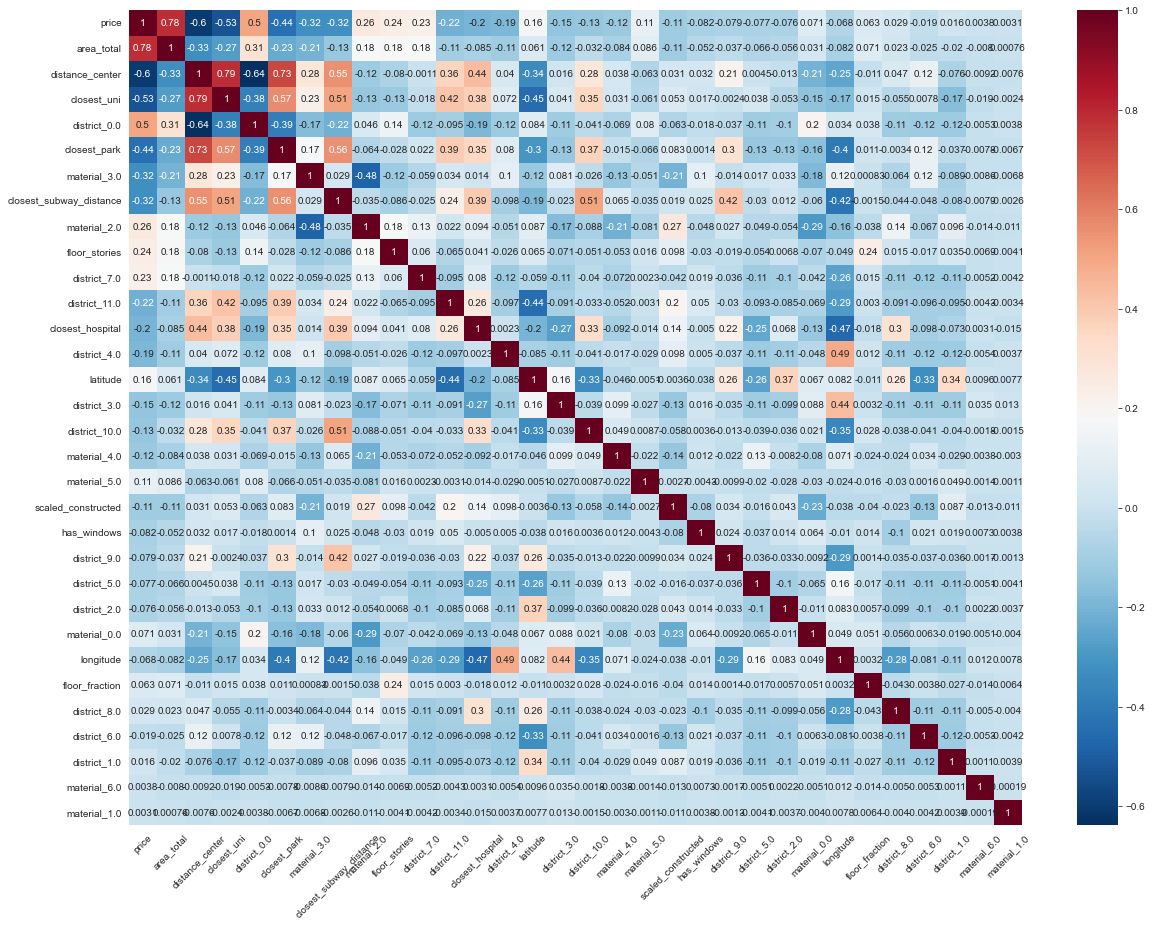

In [698]:
categorical = preprocessor.split_categorical_features(featured.copy(), ["district", "material"])
#lmao= preprocessor.remove_labels(categorical.copy(), ["material_1.0","material_6.0","district_1.0","district_6.0","district_8.0","has_elevator_1","seller_3.0","material_0.0","district_2.0","district_5.0","district_9.0"])
last = preprocessor.remove_labels(categorical.copy(), ["kitchen_fraction","area_score","rooms","avg_room_size","bathroom_amount","district","living_fraction","square_diff", "district_distance","material","seller","floor","material","has_elevator","garbage_chute","heating","parking","phones","apartment_score","bathroom_fraction","area_total_distance","area_kitchen","area_living","id","building_id","constructed","bathrooms_private","bathrooms_shared","new","windows_street","stories","windows_court","elevator_passenger","elevator_service"])
visualizer.price_correlation(last)
#squared_diff

In [745]:
# Seperating training and test data
train_data = last[:23285].copy()
labels = train_data["price"]
test_data = last[23285:].copy()
test_data.drop("price", 1, inplace=True)
print("Split data into train and test")

# Splitting training data into training and validation, removed the price for each of them afterwards
x_train, x_test, y_train, y_test = train_test_split(train_data, labels, stratify=train_data["price"].round(), test_size=0.001)
x_train.drop("price", 1, inplace=True)
x_test.drop("price", 1, inplace=True)
print("Validation data created and price dropped")
print("The number of features are now:", x_train.shape[1])

print("Fitting model...")
model = TestModel(x_train, y_train)
pipeline = model.fit()
test_pred = np.round([np.expm1(pred) for pred in model.predict(x_test)])
test_labels = np.round([np.expm1(lab)for lab in y_test])
print("Fitting complete")

res = pd.DataFrame([(test_labels[i], test_pred[i]) for i in range(len(test_pred))], columns=["actual", "prediction"])
print("RMLSE: %s" % model.root_mean_squared_log_error(test_labels, test_pred))
res.to_csv("./split.csv", index=False)

pred = [np.expm1(p) for p in model.predict(test_data)]
model.save_predictions(pred)

Split data into train and test
Validation data created and price dropped
The number of features are now: 31
Fitting model...
Fitting complete
RMLSE: 0.17240330812960267


,id,price_prediction
0,23285,30795464.0
1,23286,8657099.0
2,23287,6123418.0
3,23288,8967598.0
4,23289,5061226.0
...,...,...
9932,33217,28113972.0
9933,33218,15833591.0
9934,33219,10051992.0
9935,33220,9122518.0


In [749]:
automl_model = TestModel(x_train, y_train)
automl_model.autoMLfit(x_train, y_train, ["lgbm","rf", "xgboost"],time=100,ensemble=False)

[flaml.automl: 11-16 18:18:37] {1485} INFO - Data split method: uniform
[flaml.automl: 11-16 18:18:37] {1489} INFO - Evaluation method: holdout
[flaml.automl: 11-16 18:18:37] {1540} INFO - Minimizing error metric: log_loss
[flaml.automl: 11-16 18:18:37] {1577} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost']
[flaml.automl: 11-16 18:18:37] {1826} INFO - iteration 0, current learner lgbm


AssertionError: predict_prob() only for classification task.

In [747]:
test_pred = np.round([np.expm1(pred) for pred in automl_model.autoMLpredict(x_test)])
test_labels = np.round([np.expm1(lab)for lab in y_test])
print("Fitting complete")

res = pd.DataFrame([(test_labels[i], test_pred[i]) for i in range(len(test_pred))], columns=["actual", "prediction"])
print("RMLSE: %s" % automl_model.root_mean_squared_log_error(test_labels, test_pred))
res.to_csv("./split.csv", index=False)

pred = [np.expm1(p) for p in automl_model.predict(test_data)]
automl_model.save_predictions(pred)
automl_model.autoML_print_best_model()

Fitting complete
RMLSE: 0.07826140877261238
best model lgbm
configs {'n_estimators': 290, 'num_leaves': 383, 'min_child_samples': 2, 'learning_rate': 0.14357025802388537, 'log_max_bin': 10, 'colsample_bytree': 0.517801258265659, 'reg_alpha': 0.011572343074847936, 'reg_lambda': 0.006047099428180339}
